<a href="https://colab.research.google.com/github/bgushlaw/NewRepository/blob/main/AI_timeseries_ECG54b_30_valid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/01_Intro_to_Time_Series_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

created by Ignacio Oguiza - email: timeseriesAI@gmail.com

## Purpose 

The purpose of this notebook is to show you how you can create a simple, end-to-end, state-of-the-art time series classification model using the great **fastai-v2** library in 5 steps:
1. Import libraries
2. Prepare data
3. Build learner
4. Train model
5. Inference (predictions) on additional data

In general, there are 3 main ways to classify time series, based on the input to the neural network:

- raw data

- image data (encoded from raw data)

- feature data (extracted from raw data)

In this notebook, we will use the first approach.

## Import libraries 📚

In [1]:
pip install --user --upgrade protobuf


     |████████████████████████████████| 1.0MB 6.1MB/s 


In [4]:
stable = False # True: latest version, False: stable version
import sys
ISCOLAB = 'google.colab' in sys.modules
if ISCOLAB:
    if stable: 
        !pip install tsai -Uqq
    else:
        !pip install -Uqq git+https://github.com/timeseriesAI/tsai.git

ERROR: googleapis-common-protos 1.53.0 has requirement protobuf>=3.12.0, but you'll have protobuf 3.11.2 which is incompatible.
ERROR: google-api-core 1.26.3 has requirement protobuf>=3.12.0, but you'll have protobuf 3.11.2 which is incompatible.


In [1]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

tsai       : 0.2.18
fastai     : 2.3.1
fastcore   : 1.3.20
torch      : 1.8.1+cu101


## Prepare data 

### Download data ⬇️

Link your google drive with a folder containing the pre-wrangled data. Used jupyter notebook "TimeSeries Wrangled data to numpy 3d array"

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
X_trainECG = np.load("drive/MyDrive/AI/X_trainECG54b.npy", encoding='bytes')
X_testECG = np.load("drive/MyDrive/AI/X_testECG54b.npy", encoding='bytes')
y_trainECG = np.load("drive/MyDrive/AI/y_trainECG54b.npy", encoding='bytes')
y_testECG = np.load("drive/MyDrive/AI/y_testECG54b.npy", encoding='bytes')


In [4]:
print(X_trainECG.shape,X_testECG.shape,y_testECG.shape,y_trainECG.shape)

(44, 4, 2000) (10, 4, 2000) (10,) (44,)


☣️ **Something very important when you prepare your own data is that data needs to be in a 3-d array with the following format:**

1. Samples
2. Variables
3. Length (aka time or sequence steps)

Variables = 1 for univariate datasets and >1 for multivariate.

In the case your data is already separate between train and test like this:

you can use this convenience function to get X, y and splits:

In [72]:
X, y, splits = combine_split_data([X_trainECG, X_testECG], [y_trainECG, y_testECG])
print(X.shape)
print(y.shape)
print(splits)

(54, 4, 2000)
(54,)
([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37], [38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53])


When you use your own data, you'll have to split it yourself. I split validation set as 20% of the total data and ensured a decent distribuition of the data used. 


### Prepare datasets 

The first step is to create datasets.  

In TS classification problems, you will usually want to use an item tfm to transform y into categories. The ECG dataset is already in numerical valued ground states but in case it is not use this tool

We'll use inplace=True to preprocess data at dataset initialization. This will significantly speed up training. 

In [73]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)

We'll now build the dataloaders that will create batches of data.

You will need to pass:

* datasets: usually 2 - train and valid -  or 1 - test or unlabeled- depending on the problem
* batch size(s): you may pass a single value (will will be appied to all dls, or different values, one for each dl.
* batch_tfms (same as after_batch): you may decide to pass some tfms at the batch level. In this case for example, we'll standardize the data (0 mean and 1 std). You may get more details on how these transforms work in the transforms nb.
* num workers: num_workers > 0 is used to preprocess batches of data so that the next batch is ready for use when the current batch has been finished. More num_workers would consume more memory usage but is helpful to speed up the I/O process. This will depend on your machine, dataset, etc. You may want to start with 0, and test other values to see how to train faster. For me, 0 works better.

In [74]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[16, 32], batch_tfms=[TSStandardize()], num_workers=0)

### Visualize data

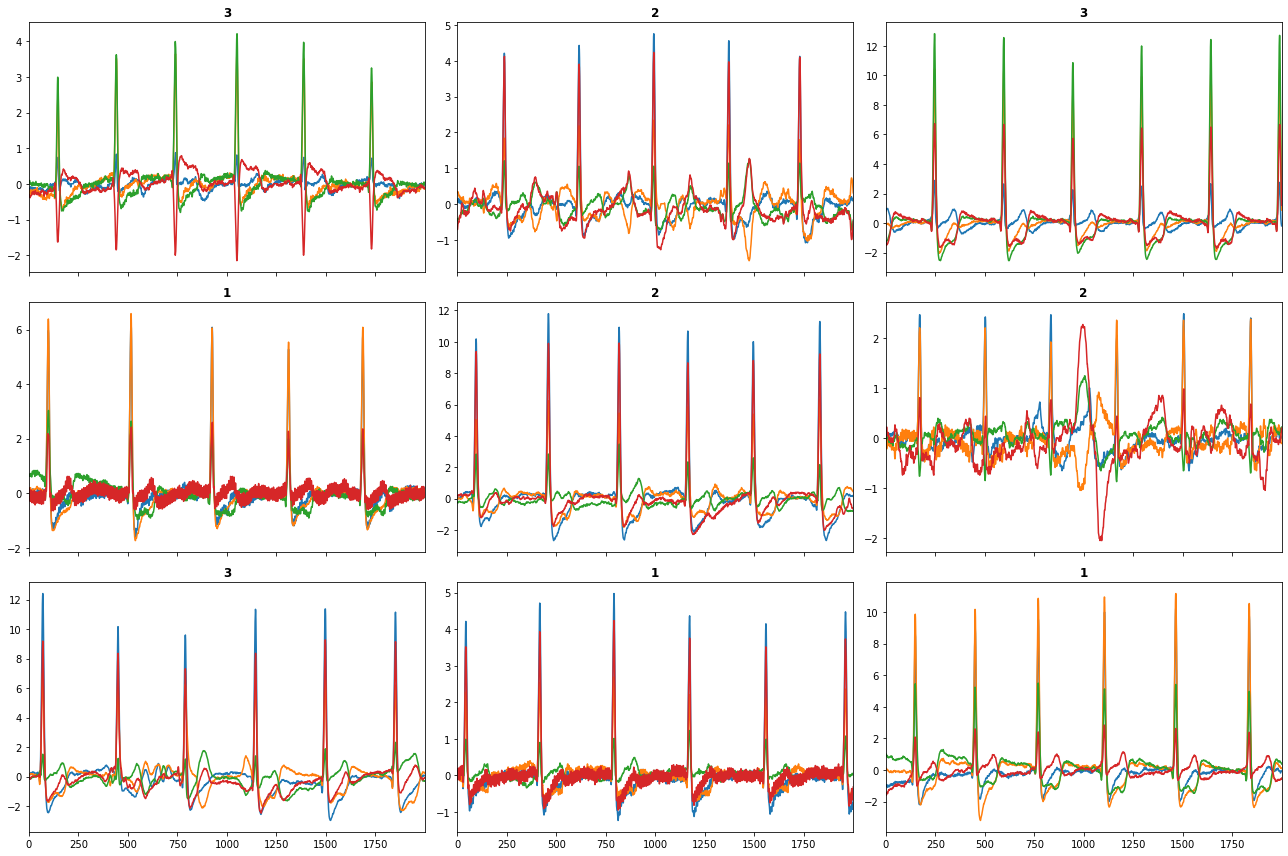

In [75]:
dls.show_batch(sharey=False)

## Build learner 

In [76]:
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.save('TimeSeriesECG1')

Path('models/TimeSeriesECG1.pth')

## Train model 

### LR find 🔎

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(lr_min=0.003981071710586548, lr_steep=0.0691830962896347)

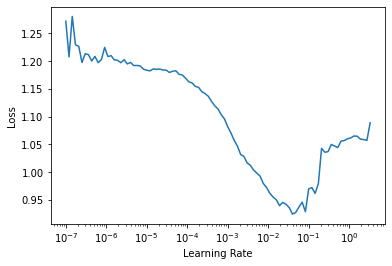

In [77]:
learn.load('TimeSeriesECG1')
learn.lr_find(suggestions=True)

### Train 🏃🏽‍♀️

In [87]:
learn.load('TimeSeriesECG1')
learn.fit_one_cycle(25, lr_max=1e-3)
learn.save('TimeSeriesECG2')

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


epoch,train_loss,valid_loss,accuracy,time
0,1.228373,1.144204,0.250000,00:00
1,1.188459,1.145422,0.250000,00:00
2,1.184283,1.145065,0.250000,00:00
3,1.158855,1.139434,0.250000,00:00
4,1.133609,1.123289,0.250000,00:00
5,1.094515,1.096123,0.250000,00:00
6,1.059378,1.073032,0.375000,00:00
7,1.014531,1.018419,0.625000,00:00
8,0.992050,0.988054,0.562500,00:00
9,0.953478,0.990665,0.437500,00:00


Path('models/TimeSeriesECG2.pth')

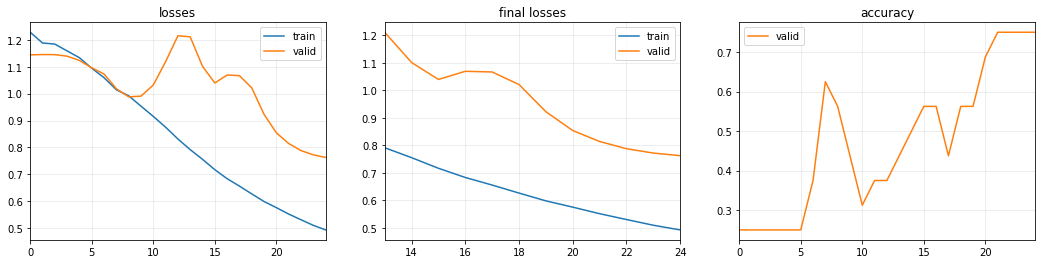

In [88]:
learn.recorder.plot_metrics()

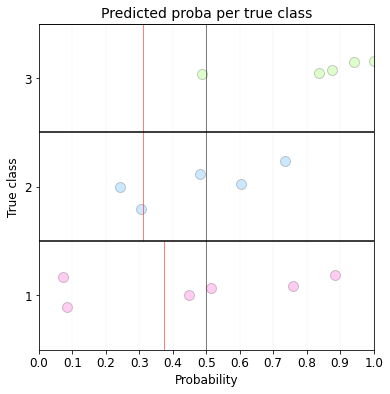

In [89]:
learn.show_probas()

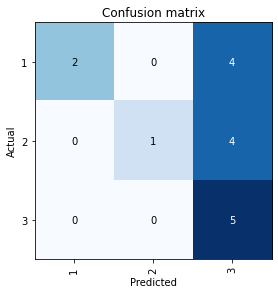

In [90]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [91]:
learn.save_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')

As soon as we've done this, we can end the session, and continue at any time in the future. 

Let's simulate that we need to end the session now:

In [92]:
del learn, dsets, dls

Next time we go back to work, we'll need to reload the datasets and learner (with the same status we had):

In [93]:
learn = load_learner_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')
dls = learn.dls
valid_dl = dls.valid
b = next(iter(valid_dl))
b

(TSTensor(samples:16, vars:4, len:2000),
 TensorCategory([0, 2, 1, 0, 1, 0, 2, 1, 0, 2, 2, 1, 0, 1, 2, 0], device='cuda:0'))

In [94]:
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
valid_probas, valid_targets, valid_preds

(tensor([[9.9650e-02, 8.3153e-02, 8.1720e-01],
         [4.2832e-03, 7.1830e-03, 9.8853e-01],
         [3.6099e-01, 2.4920e-01, 3.8982e-01],
         [7.0848e-02, 3.5350e-01, 5.7566e-01],
         [5.6187e-02, 6.7165e-01, 2.7216e-01],
         [6.1153e-01, 1.9529e-01, 1.9319e-01],
         [5.5023e-07, 1.6545e-05, 9.9998e-01],
         [7.8358e-03, 1.2159e-02, 9.8001e-01],
         [1.7626e-02, 2.1917e-02, 9.6046e-01],
         [4.3368e-02, 1.2473e-01, 8.3190e-01],
         [2.1039e-02, 2.9717e-01, 6.8179e-01],
         [2.3249e-02, 3.3922e-02, 9.4283e-01],
         [4.8105e-02, 3.8293e-01, 5.6897e-01],
         [1.8196e-02, 6.1262e-02, 9.2054e-01],
         [5.7604e-02, 1.4477e-01, 7.9763e-01],
         [4.5706e-01, 3.2797e-01, 2.1497e-01]]),
 TensorCategory([0, 2, 1, 0, 1, 0, 2, 1, 0, 2, 2, 1, 0, 1, 2, 0]),
 tensor([2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0]))

We can confirm the learner has the same status it had at the end of training, by confirming the validation accuracy is the same:

In [95]:
(valid_targets == valid_preds).float().mean()

TensorCategory(0.5000)

Great! It's the same. This means we have now the learner at the same point where we left it.

## Visualize results 👁

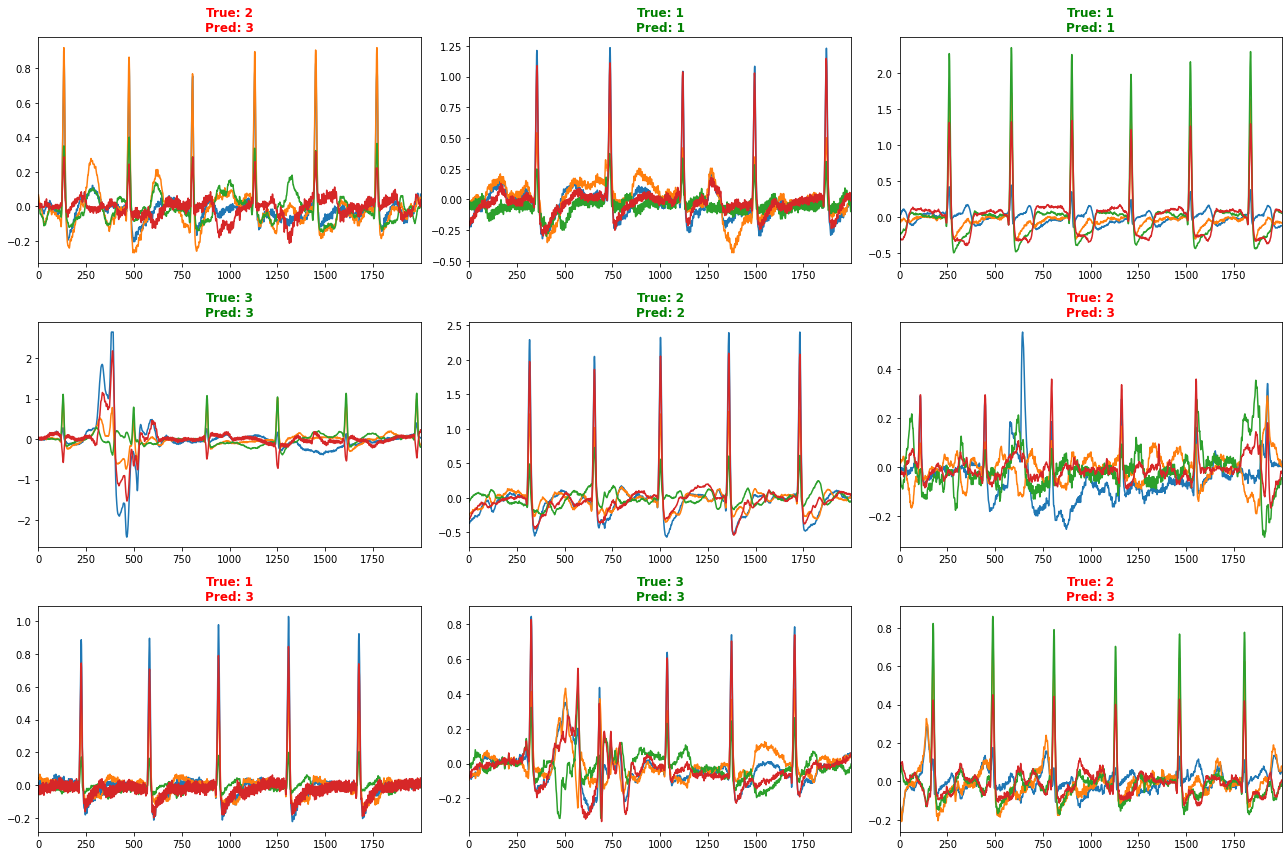

In [96]:
learn.show_results()

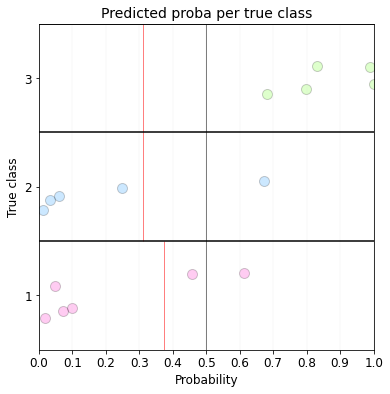

In [97]:
learn.show_probas()

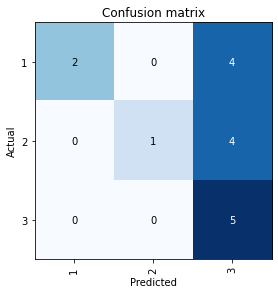

In [98]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [99]:
interp.most_confused(min_val=1)

[(1, 3, 4), (2, 3, 4)]

## Inference on additional data 🆕

Let's say we want to predict labels on new data. Let's see how this works.

We may have additional data (test set) where we want to check our performance. In this case, we'd add a labeled dataset:

In [62]:
# Labeled test data
test_ds = valid_dl.dataset.add_test(X, y)# In this case I'll use X and y, but this would be your test data
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

(TSTensor(samples:10, vars:4, len:2000),
 TensorCategory([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))

By selecting the valid dataset (valid_dl.dataset) we ensure that the same tfms applied to the valid data will be applied to the new data.

In [63]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas, test_targets, test_preds

(tensor([[0.4888, 0.0313, 0.4799],
         [0.4951, 0.0673, 0.4377],
         [0.3659, 0.2067, 0.4274],
         [0.3820, 0.0508, 0.5671],
         [0.4670, 0.0512, 0.4819],
         [0.4653, 0.0557, 0.4791],
         [0.4448, 0.2048, 0.3504],
         [0.4473, 0.0132, 0.5395],
         [0.4139, 0.0312, 0.5549],
         [0.3907, 0.3075, 0.3018],
         [0.4272, 0.0089, 0.5639],
         [0.4203, 0.0099, 0.5698],
         [0.3823, 0.0274, 0.5902],
         [0.4103, 0.0152, 0.5745],
         [0.3957, 0.0091, 0.5952],
         [0.3959, 0.0076, 0.5964],
         [0.4585, 0.1259, 0.4156],
         [0.4745, 0.1382, 0.3872],
         [0.3690, 0.1327, 0.4983],
         [0.3299, 0.2234, 0.4466],
         [0.3311, 0.2439, 0.4250],
         [0.2933, 0.3395, 0.3672],
         [0.3847, 0.0815, 0.5338],
         [0.3652, 0.1120, 0.5228],
         [0.3371, 0.2461, 0.4167],
         [0.3329, 0.3043, 0.3627],
         [0.1591, 0.5466, 0.2943],
         [0.2459, 0.3844, 0.3697],
         [0.2781, 0.

In [64]:
print(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')

accuracy:   0.425926


If data is unlabeled, we'd just do this: 

In [65]:
# Unlabeled data
test_ds = dls.dataset.add_test(X)
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

(TSTensor(samples:10, vars:4, len:2000),)

In [66]:
test_probas, *_ = learn.get_preds(dl=test_dl, save_preds=None)
test_probas

tensor([[0.4888, 0.0313, 0.4799],
        [0.4951, 0.0673, 0.4377],
        [0.3659, 0.2067, 0.4274],
        [0.3820, 0.0508, 0.5671],
        [0.4670, 0.0512, 0.4819],
        [0.4653, 0.0557, 0.4791],
        [0.4448, 0.2048, 0.3504],
        [0.4473, 0.0132, 0.5395],
        [0.4139, 0.0312, 0.5549],
        [0.3907, 0.3075, 0.3018],
        [0.4272, 0.0089, 0.5639],
        [0.4203, 0.0099, 0.5698],
        [0.3823, 0.0274, 0.5902],
        [0.4103, 0.0152, 0.5745],
        [0.3957, 0.0091, 0.5952],
        [0.3959, 0.0076, 0.5964],
        [0.4585, 0.1259, 0.4156],
        [0.4745, 0.1382, 0.3872],
        [0.3690, 0.1327, 0.4983],
        [0.3299, 0.2234, 0.4466],
        [0.3311, 0.2439, 0.4250],
        [0.2933, 0.3395, 0.3672],
        [0.3847, 0.0815, 0.5338],
        [0.3652, 0.1120, 0.5228],
        [0.3371, 0.2461, 0.4167],
        [0.3329, 0.3043, 0.3627],
        [0.1591, 0.5466, 0.2943],
        [0.2459, 0.3844, 0.3697],
        [0.2781, 0.3226, 0.3993],
        [0.278

## Summary ✅

This is all the code you need to train a TS model. As you can see, it's v2 is easier to use and faster compared to v1.

epoch,train_loss,valid_loss,accuracy,time
0,2.016535,1.859699,0.122222,00:00
1,1.906437,1.850784,0.127778,00:00
2,1.737429,1.838830,0.122222,00:00
3,1.575056,1.819059,0.122222,00:00
4,1.404516,1.783420,0.150000,00:00
5,1.249674,1.714531,0.355556,00:00
6,1.115817,1.604735,0.411111,00:00
7,1.007130,1.454872,0.577778,00:00
8,0.914946,1.296214,0.722222,00:00
9,0.843145,1.146225,0.700000,00:00


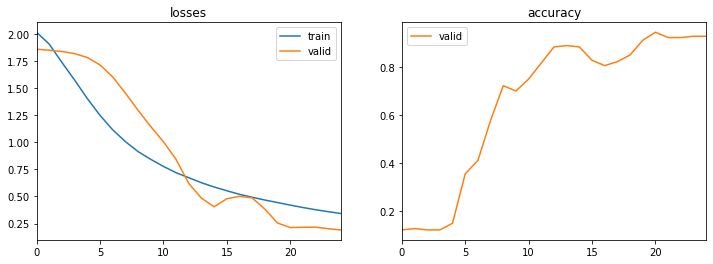

In [ ]:
dsid = 'NATOPS' 
X, y, splits = get_UCR_data(dsid, return_split=False)
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.fit_one_cycle(25, lr_max=1e-3)
learn.plot_metrics()

## New scikit-learn-like API 🎉

As of `tsai` version 0.2.15 I have added a new scikit-learn-like API to further simplify the learner creation. 

I will prepare a new tutorial to further demonstrate how you can use the new API.

This is how you can use it for Time Series Classification: 

epoch,train_loss,valid_loss,accuracy,time
0,1.950792,1.832381,0.127778,00:00
1,1.851009,1.819222,0.127778,00:00
2,1.683752,1.803457,0.144444,00:00
3,1.511847,1.778563,0.211111,00:00
4,1.344290,1.734831,0.305556,00:00
5,1.186986,1.650455,0.572222,00:00
6,1.066000,1.517141,0.650000,00:00
7,0.969655,1.345964,0.683333,00:00
8,0.886274,1.158084,0.744444,00:00
9,0.812390,0.972392,0.855556,00:00


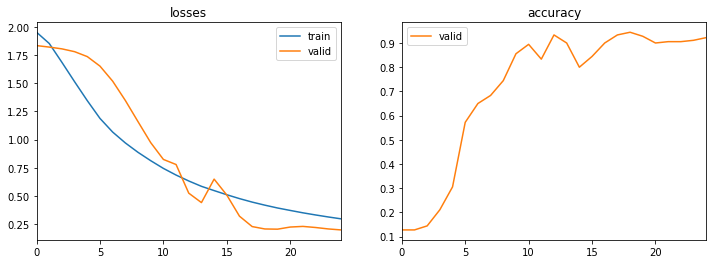

In [ ]:
dsid = 'NATOPS' 
X, y, splits = get_UCR_data(dsid, return_split=False)
learn = TSClassifier(X, y, splits=splits, bs=[64, 128], batch_tfms=[TSStandardize()], arch=InceptionTime, metrics=accuracy)
learn.fit_one_cycle(25, lr_max=1e-3)
learn.plot_metrics()